(continuous_hgf)=
# The continuous Hirarchical Gaussian Filter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ghgf import load_data
from ghgf.model import HGF
import seaborn as sns

sns.set_context("talk")

In this example, we will use the exchange rate of the US Dollar to the Swiss Franc during much of 2010 and 2011 as a time series that the Hierarchical Gaussian Filter is going to predict.

## Data import

In [3]:
timeserie = load_data("continuous")

## Using a two-levels model

In [4]:
two_levels_hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 1.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": -13.0, "2": -6.0},
    rho={"1": 0.0, "2": 0.0},
    kappas={"1": 1.0}).input_data(
        input_data=timeserie
    )

Creating a continuous Hierarchical Gaussian Filter with 2 levels.
Add 614 new continuous observations.


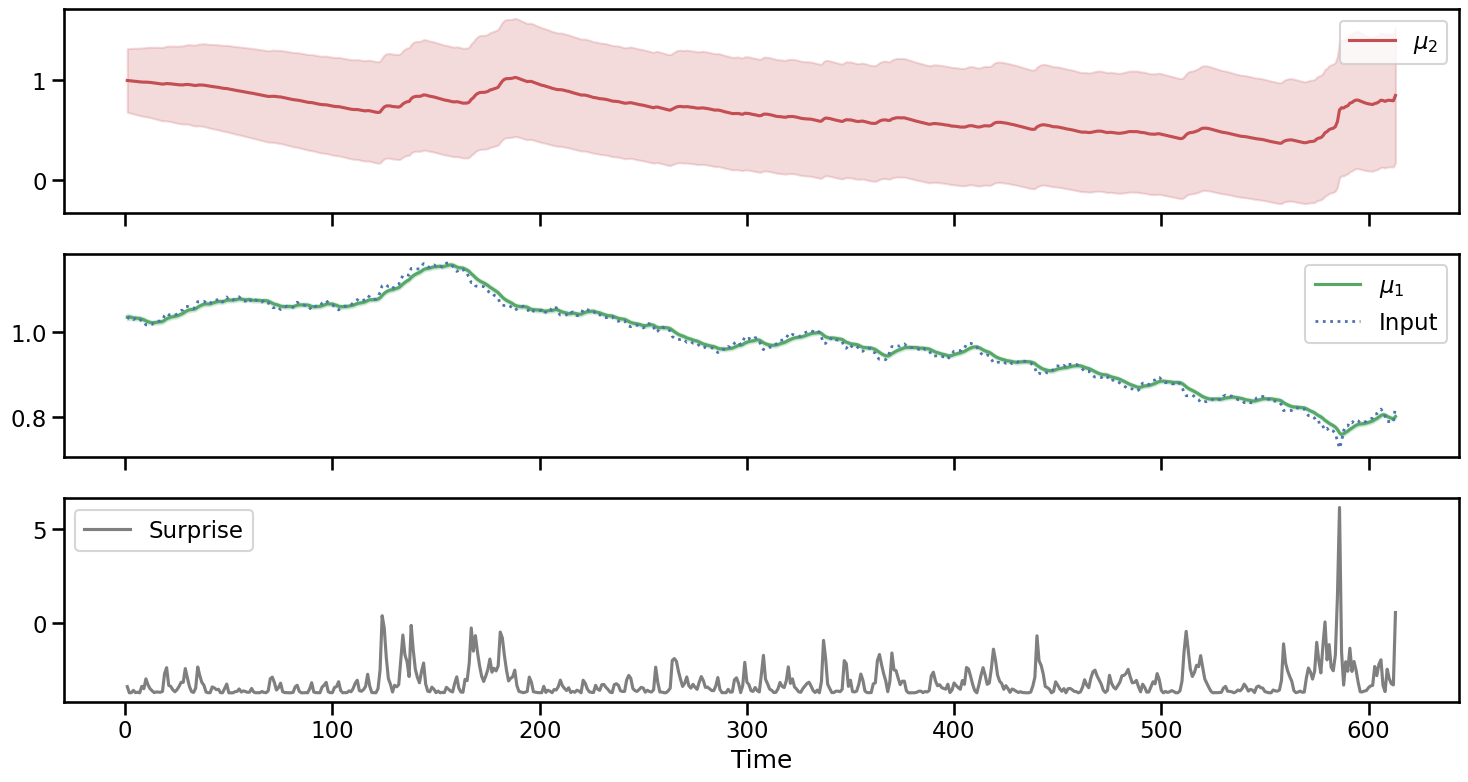

In [5]:
two_levels_hgf.plot_trajectories()

We can see that the surprise will increase when the time series exhibit more unexpected behaviors. The degree to which a given observation is expected will deppends on the expeted value and volatility in the input node, that are influenced by the values of higher order nodes. One way to assess model fit is to look at the total gaussian surprise for each observation. This values can be returned using the `surprise` method:

In [6]:
two_levels_hgf.surprise()

DeviceArray(-1921.5396, dtype=float32)

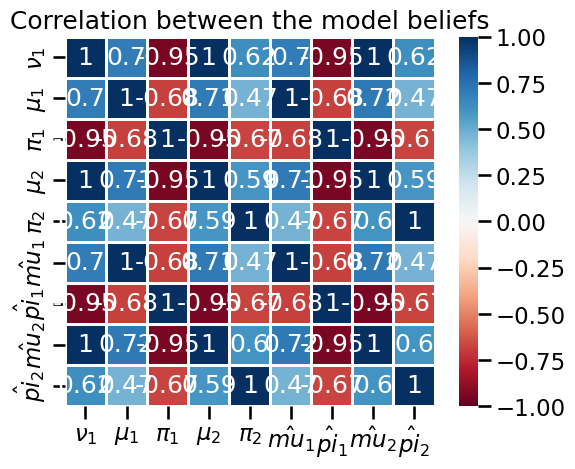

In [7]:
two_levels_hgf.plot_correlations()

The model fit will directly be influenced by the model parameters. One important parameters for each node is $\omega$ (`omega`). This is the tonic part of the variance (the part of the variance in each node that is not affected by the parent node). Here we are going to change $\omega$ for both the first and the second level:

In [8]:
hgf_high_omega = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 1.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": -2.0, "2": -1.0},
    rho={"1": 0.0, "2": 0.0},
    kappas={"1": 1.0}).input_data(
        input_data=timeserie
    )

Creating a continuous Hierarchical Gaussian Filter with 2 levels.
Add 614 new continuous observations.


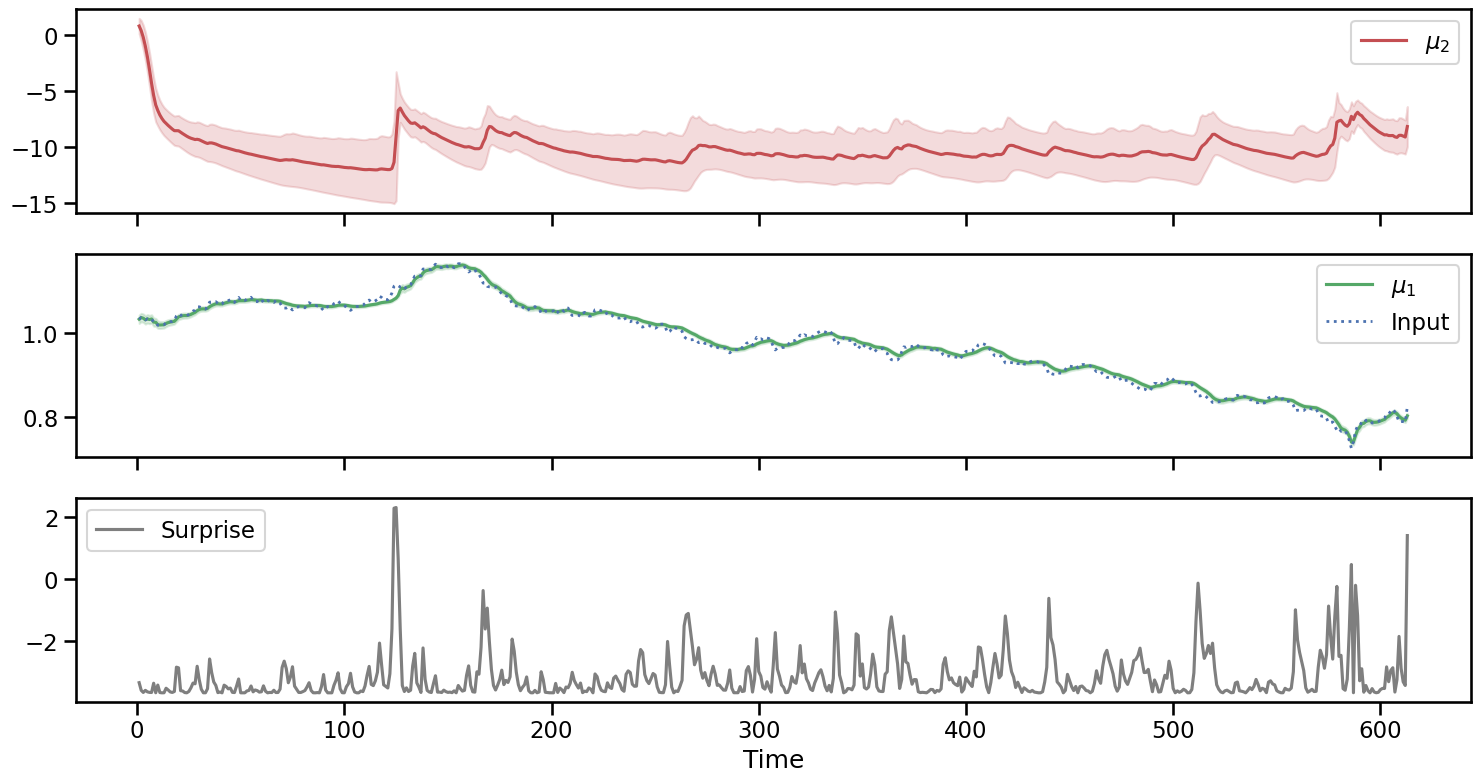

In [9]:
hgf_high_omega.plot_trajectories()

In [10]:
hgf_high_omega.surprise()

DeviceArray(-1947.0228, dtype=float32)

## Using a three-level model
### Create the model

In [11]:
three_levels_hgf = HGF(
    n_levels=3,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 1.0, "3": 1.0},
    initial_pi={"1": 1e4, "2": 1e1, "3": 1e1},
    omega={"1": -13.0, "2": -6.0, "3": -2.0},
    rho={"1": 0.0, "2": 0.0, "3": 0.0},
    kappas={"1": 1.0, "2": 1.0})

Creating a continuous Hierarchical Gaussian Filter with 3 levels.


### Add data

In [12]:
# Provide new observations
three_levels_hgf.input_data(input_data=timeserie)

Add 614 new continuous observations.


### Plot trajectories

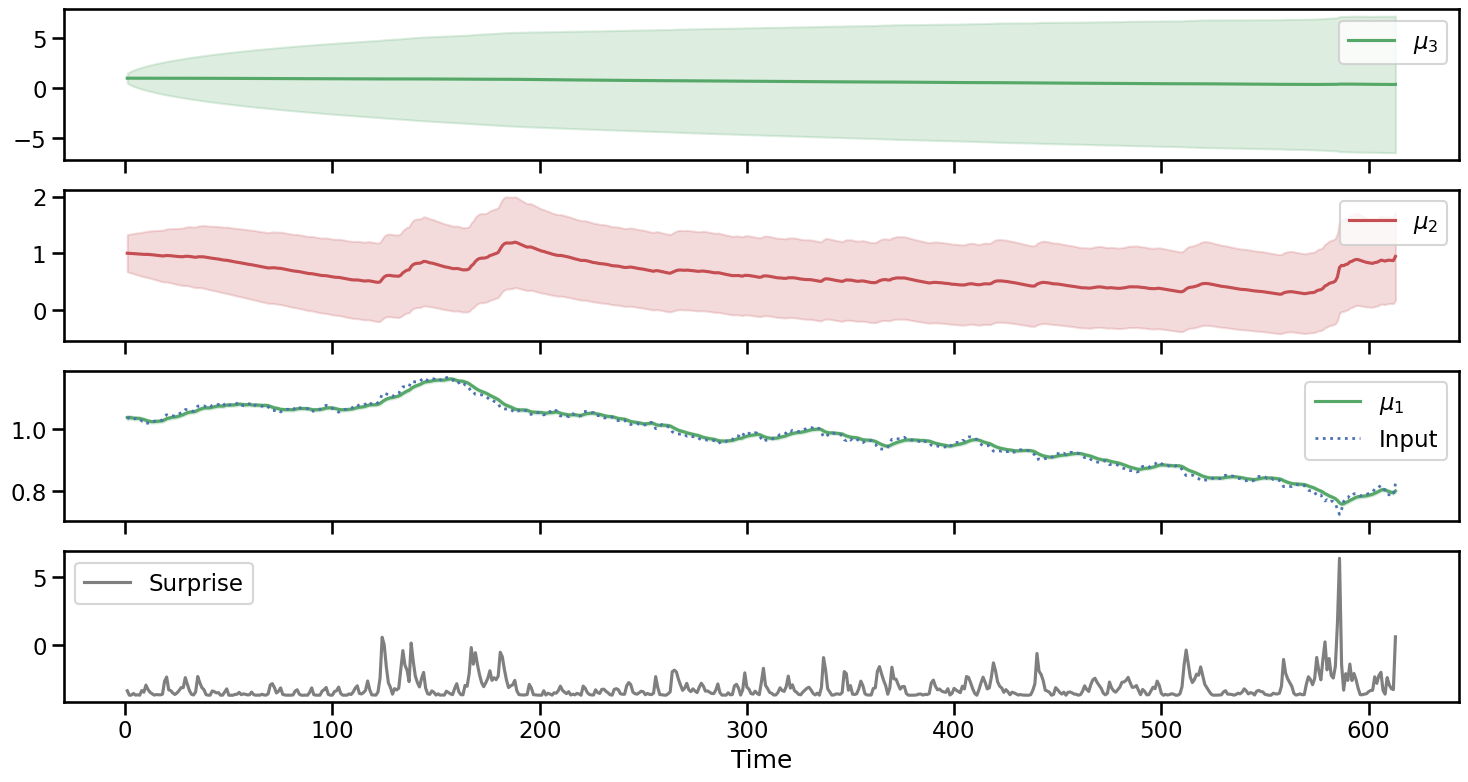

In [13]:
three_levels_hgf.plot_trajectories()

## Learning parameters with MCMC sampling
In the previous section, we assumed we knew the parameters of the HGF models that were used to filter the input data. This can give us information on how an agent using these values would behave when presented with these inputs. We can also adopt a different perspective and consider that we want to learn these parameters from the data. Here, we are going to set some of the parameters free and use Hamiltonian Monte Carlo methods (NUTS) to sample their probability density.

Because the HGF classes are built on the top of [JAX](https://github.com/google/jax), they are natively differentiable and compatible with optimisation libraries or can be embedded as regular distributions in the context of a Bayesian network. Here, we are using this approach, and we are going to use [PyMC](https://www.pymc.io/welcome.html) to perform this step. PyMC can use any log probability function (here the negative surprise of the model) as a building block for a new distribution by wrapping it in its underlying tensor library [Aesara](https://aesara.readthedocs.io/en/latest/), now forked as [PyTensor](https://pytensor.readthedocs.io/en/latest/). This PyMC-compatible distribution can be found in the :py:`ghgf.distribution` sub-module.

In [16]:
import pymc as pm
import arviz as az
from ghgf.distribution import HGFDistribution
from ghgf.response import gaussian_surprise

### Creating the model

In [17]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    input_data=[timeserie]
)

This log probabilit function can then be embedded in a PyMC model using the same API. Here, we are going to set `omega_1`, `omega_2` and `mu_1` as free parameters. The other parameters are fixed.

```{note}
The data is being passed to the distribution when the instance is created.
```

In [18]:
with pm.Model() as two_level_hgf:
    
    # Mus priors
    mu_1 = pm.Normal("mu_1", 0, 10)
    mu_2 = pm.Normal("mu_2", 0, 10)

    # Omegas priors
    omega_1 = pm.Normal("omega_1", -6.0, 2)
    normal_dist = pm.Normal.dist(mu=-2.0, sigma=2.0)
    omega_2 = pm.Censored("omega_2", normal_dist, lower=-20.0, upper=2)

    pm.Potential(
        "hhgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=omega_2,
            omega_input=np.log(1e-4),
            rho_1=np.array(0.0),
            rho_2=np.array(0.0),
            pi_1=np.array(1e4),
            pi_2=np.array(1e1),
            mu_1=mu_1,
            mu_2=mu_2,
            kappa_1=np.array(1.0),
            bias=np.array(0.0),
        ),
    )

```{note}
The $\omega$ parameters are real numbers that are defined from -$\infty$ to +$\infty$. However, as learning rates expressed in log spaces, values higher than 2 are extremely unlikely and could create abberant fits to the data. Therefore, here we are constraining the parameter space using a censored normal distribution (see [pm.Censored](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Censored.html)) that exclude any value higher that 2.0.
```

### Visualizing the model

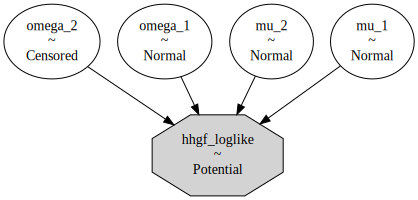

In [19]:
pm.model_to_graphviz(two_level_hgf)

### Sampling

In [54]:
with two_level_hgf:
    two_level_hgf_idata = pm.sample(chains=4)

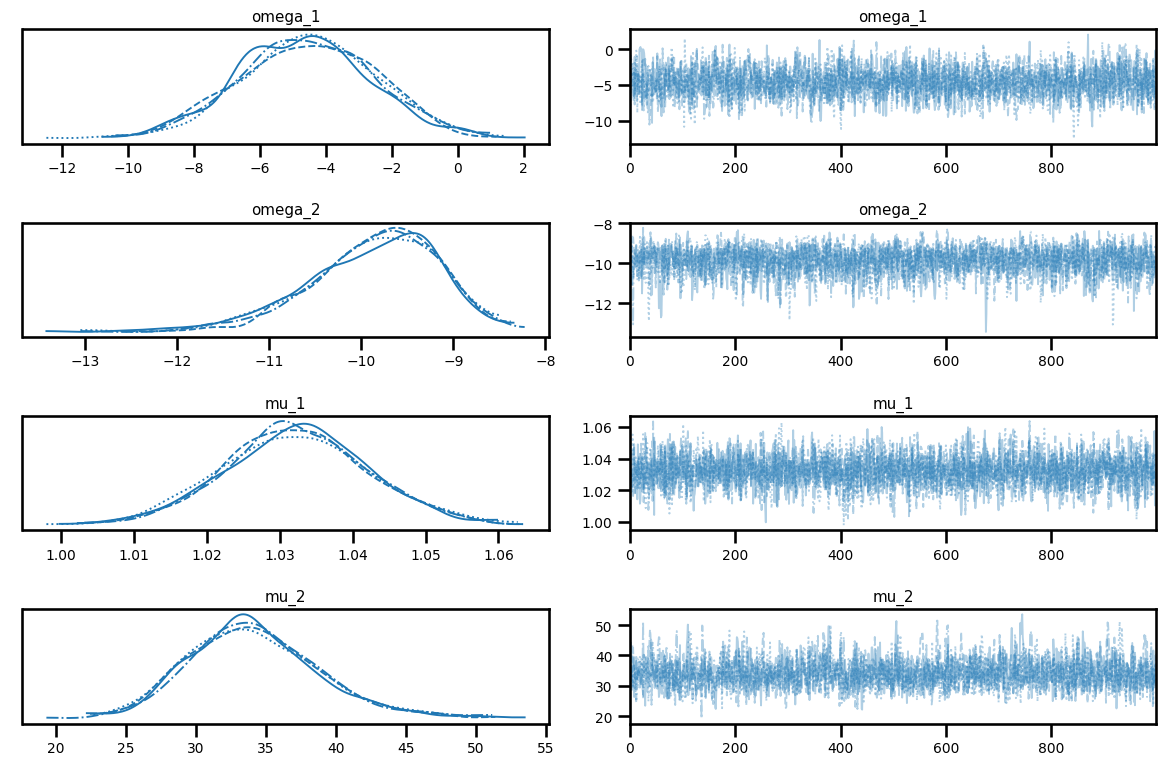

In [56]:
az.plot_trace(two_level_hgf_idata, var_names=["omega_1", "omega_2", "mu_1", "mu_2"]);
plt.tight_layout()

### Visualizing the most likely model

In [60]:
omega_1 = az.summary(two_level_hgf_idata)["mean"]["omega_1"]
omega_2 = az.summary(two_level_hgf_idata)["mean"]["omega_2"]
mu_1 = az.summary(two_level_hgf_idata)["mean"]["mu_1"]
mu_2 = az.summary(two_level_hgf_idata)["mean"]["mu_2"]

In [63]:
hgf_mcmc = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": mu_1, "2": mu_2},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": omega_1, "2": omega_2},
    rho={"1": 0.0, "2": 0.0},
    kappas={"1": 1.0}).input_data(
        input_data=timeserie
    )

Creating a continuous Hierarchical Gaussian Filter with 2 levels (JAX backend).
Add 614 new continuous observations.


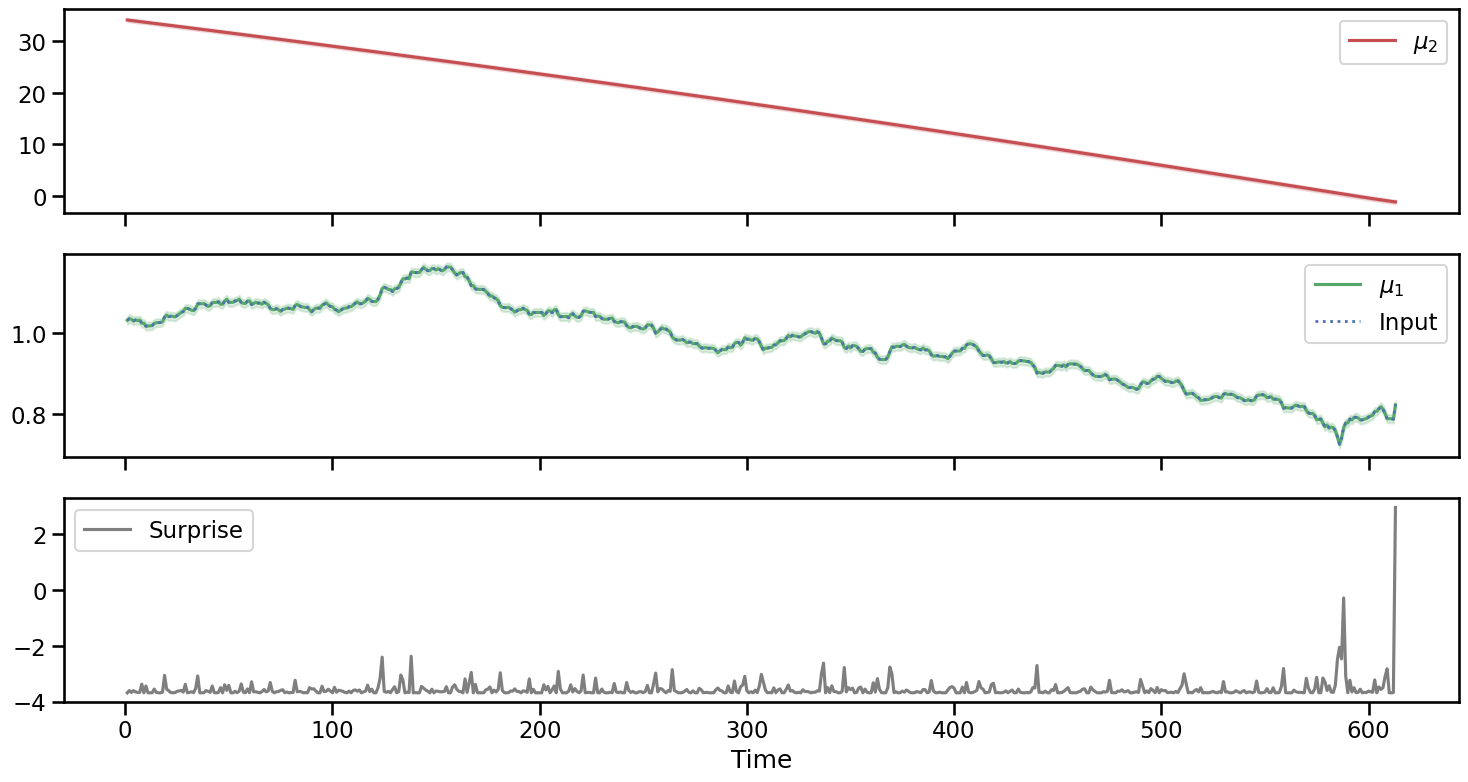

In [64]:
hgf_mcmc.plot_trajectories()

In [42]:
hgf_mcmc.surprise()

DeviceArray(-2150.2424, dtype=float32)

Looking at the volatility (ie, the second) level, we see that there are two salient events in our time series where volatility shoots up. The first is in April 2010 when the currency markets react to the news that Greece is effectively broke. This leads to a flight into the US dollar (green dots rising very quickly), sending the volatility higher. The second is an accelarating increase in the value of the Swiss Franc in Augutst and September 2011, as the Euro crisis drags on. The point where the Swiss central bank intervened and put a floor under how far the Euro could fall with respect to the Franc is clearly visible in the Franc's valuation against the dollar. This surprising intervention shows up as another spike in volatitlity.

## System configuration

In [43]:
%load_ext watermark
%watermark -n -u -v -iv -w -p ghgf,jax,jaxlib

Last updated: Thu Jan 19 2023

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

ghgf  : 0.0.1.dev0
jax   : 0.3.5
jaxlib: 0.3.22

arviz     : 0.13.0
numpy     : 1.19.0
seaborn   : 0.12.1
matplotlib: 3.4.3
pymc      : 5.0.1

Watermark: 2.3.1

